In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#
#%cd /content/drive/My \Drive/Colab \Notebooks/Optimal \Transport/Repository

Mounted at /content/drive


In [6]:
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
%matplotlib inline

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd
from torch.autograd import Variable

import wandb
import os

import torchvision.datasets as datasets
from torchvision import transforms

from IPython.display import clear_output

from PIL import Image
from torchvision import models

from tqdm.notebook import tqdm as tqdm
import ot

from networks import resnet_d, conv_icnn32, unet, dense_icnn
from networks.resnet_d import weights_init_D

from utils import fig2data, fig2img, plot_images

In [7]:
import random
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything()

## Loading the datasets
The batch size is big since I use the loaded data for pairing.

In [8]:
IMG_SIZE = 32 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

CHANNELS = 3
BATCH_SIZE = 60000

#Extending the channels if required
if CHANNELS == 3:
  TRANSFORM = transforms.Compose([
      transforms.Lambda(lambda x: x.convert('RGB')),
      transforms.Resize(IMG_SIZE),
      transforms.ToTensor(),
      #transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])

if CHANNELS == 1:
  TRANSFORM = transforms.Compose([
      transforms.Resize(IMG_SIZE),
      transforms.ToTensor(),
      transforms.Normalize([0.5], [0.5])
  ])

# Load train datasets
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM)
fmnist_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=TRANSFORM)

mnist_loader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
fmnist_loader = torch.utils.data.DataLoader(fmnist_train, batch_size=BATCH_SIZE, shuffle=True)

# Load test datasets
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=TRANSFORM)
fmnist_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=TRANSFORM)

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE)
fmnist_test_loader = torch.utils.data.DataLoader(fmnist_test, batch_size=BATCH_SIZE)

X = next(iter(mnist_test_loader))[0]#.squeeze(1).expand(-1, IMG_SIZE, IMG_SIZE, 3)
Y = next(iter(fmnist_test_loader))[0]


del mnist_test_loader, fmnist_test_loader, mnist_test, fmnist_test


100%|██████████| 9912422/9912422 [00:00<00:00, 10787913.19it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 7201028.05it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 6980608.62it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 2258241.91it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 26421880/26421880 [00:26<00:00, 984928.88it/s] 


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 491946.46it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:10<00:00, 416532.60it/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 2025351.94it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



## POT pairing
Using the POT library for manual training to pair the dataset, I use the domain adaptation submodule

torch.Size([10000, 3072])
torch.Size([3072])
torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])


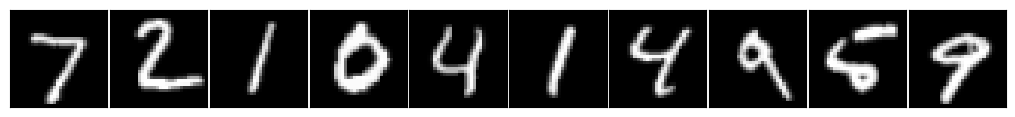

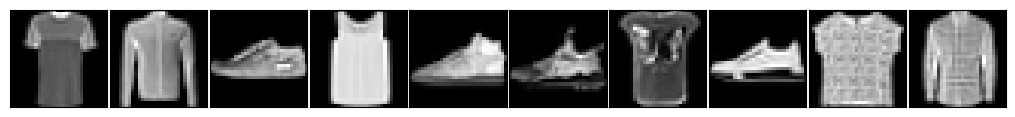

In [9]:
Xs = X.reshape(-1, CHANNELS * IMG_SIZE**2)
Xt = Y.reshape(-1, CHANNELS * IMG_SIZE**2)

ot_emd = ot.da.EMDTransport()
ot_emd.fit(Xs=Xs[:BATCH_SIZE], Xt=Xt[:BATCH_SIZE])

transp_Xt_emd = ot_emd.transform(Xs=Xs)
print(transp_Xt_emd.shape)
test_idx = 1

print(Xs[test_idx].shape)

if CHANNELS == 3:
  image_original = np.transpose(Xs[test_idx].reshape(CHANNELS, IMG_SIZE, IMG_SIZE), (1,2,0))
  image_transformed = np.transpose(transp_Xt_emd[test_idx].reshape(CHANNELS, IMG_SIZE, IMG_SIZE), (1,2,0))

if CHANNELS == 1:
  image_original = Xs[test_idx].reshape(IMG_SIZE, IMG_SIZE)
  image_transformed = transp_Xt_emd[test_idx].reshape(IMG_SIZE, IMG_SIZE)

PAIRS_TO_PICK = 10

X_test_paired = X[:].reshape(-1, 3, IMG_SIZE, IMG_SIZE)[:PAIRS_TO_PICK]
Y_test_paired = transp_Xt_emd.reshape(-1, 3, IMG_SIZE, IMG_SIZE)[:PAIRS_TO_PICK]

plot_images(X_test_paired, cmap='gray')
plot_images(Y_test_paired, cmap='gray')

print(X_test_paired.shape)
print(Y_test_paired.shape)

## Convolutional networks training

In [10]:
def get_histogram(values_dict, epoch):
  x_cur_list = []

  for el in values_dict:
      x_cur_list.extend(list(el.reshape(-1)))

  fig, axes = plt.subplots(1, 1, figsize=(10,5), dpi=100)

  axes.hist(x_cur_list, bins=50, label=f'Mean: {np.round(np.mean(x_cur_list), 4)}')
  axes.legend()
  axes.grid()
  axes.set_xlabel(f'Value of the weight for epoch {epoch}')
  axes.set_ylabel('Amount of weights')
  #axes.set_label()
  
  buf = fig2data (fig)
  w, h, d = buf.shape
     
  del x_cur_list
  return Image.frombytes("RGBA", (w ,h), buf.tostring())

In [38]:
def train_conv(model_dict, X_train, Y_train, X_test, Y_test, lamb, EPOCHS, BATCH_SIZE_LOOP, EPOCH_REPORT):
    
    model_name = list(model_dict.keys())[0]
    phi = model_dict[model_name]


    normal_losses = {}
    reg_losses = {}
    total_losses = {}
    w_epoch = {}

    try:
        for epoch in range(EPOCHS):

            permutation = torch.randperm(X_train.size()[0])

            for i in range(0, X_train.size()[0], BATCH_SIZE_LOOP):
                phi.zero_grad()
                
                indices = permutation[i:i+BATCH_SIZE_LOOP]
                image_x, image_y = X_train[indices].to(DEVICE), Y_train[indices].to(DEVICE)

                out = phi(image_x)

                out = torch.autograd.grad(out, image_x, create_graph=True, retain_graph=True, only_inputs=True, grad_outputs=torch.ones(image_x.size()[0]).cuda().float())[0]

                #####################################################
                w_hist = []
                w_reg = []
                regularizer = nn.ReLU()
                param_reg = 0
                
                param_reg = sum(regularizer(-param).sum() for param in phi.convex.parameters())
                w_reg.append(param_reg.cpu().detach().numpy())

                for layer in phi.convex:
                    if (isinstance(layer, nn.Linear)) or (isinstance(layer, nn.Conv2d)):
                        param_hist = torch.clone(layer.weight.data).detach().cpu().numpy()
                        w_hist.append(param_hist)

                w_epoch[str(epoch)] = w_hist.copy()
                
                del param_hist, w_hist
                #######################################################

                loss = criterion(out, image_y) 

                total_loss = loss + lamb*param_reg
                total_loss.backward()

                optimizer.step()

                #print(total_loss)


                if str(lamb) in normal_losses.keys():
                    normal_losses[(str(lamb), epoch)].append(loss.item())
                    reg_losses[(str(lamb), epoch)].append(w_reg[0])
                    total_losses[(str(lamb), epoch)].append(total_loss.item())
                else:
                    normal_losses[(str(lamb), epoch)] = [loss.item()]
                    reg_losses[(str(lamb), epoch)] = [w_reg[0]]
                    total_losses[(str(lamb), epoch)] = [total_loss.item()]
                
                if CONVEXIFY:
                    phi.convexify()

            normal_losses[(str(lamb), epoch)] = np.mean(normal_losses[(str(lamb), epoch)])
            reg_losses[(str(lamb), epoch)] = np.mean(reg_losses[(str(lamb), epoch)])
            total_losses[(str(lamb), epoch)] = np.mean(total_losses[(str(lamb), epoch)])

            if epoch % EPOCH_REPORT == 0:
                clear_output(wait=True)
                print(f'Epoch: {epoch}/{EPOCHS}')
                wandb.log({f"{loss_name}": normal_losses[(str(lamb), epoch)]}, step=epoch)
                wandb.log({"Reg": reg_losses[(str(lamb), epoch)]}, step=epoch)
                wandb.log({"Total loss": total_losses[(str(lamb), epoch)]}, step=epoch)
        
                print('Training loss: ', loss.item())

                if model_name == 'resnet_d':
                    out = phi(X_test).squeeze(1)
                else:
                    out = phi(X_test)

                if model_name != 'unet':
                    out = torch.autograd.grad(out, X_test, create_graph=True, retain_graph=True, only_inputs=True, grad_outputs=torch.ones(X_test.size()[0]).cuda().float())[0]

                fig1 = plot_images(X_test.cpu().detach().numpy(), 10, cmap)
                fig2 = plot_images(out.cpu().detach().numpy(), 10, cmap)
                wandb.log({'Images' : [wandb.Image(fig2img(fig1)), wandb.Image(fig2img(fig2))]}, step=epoch) 

                hist = get_histogram(w_epoch[str(epoch)], epoch);

                wandb.log({'Histograms':wandb.Image(hist)}, step=epoch)
                del hist, w_epoch
                w_epoch = {}

                plt.show()
                
    except KeyboardInterrupt:
        print('Interrupting by keyboard, returning trained model...')
        return phi

    return phi

In [41]:
model_name = 'conv_icnn'
CONVEXIFY = False
loss_name = 'l1_loss'

#losses = {'l1_loss':F.l1_loss, 'l2_loss':F.mse_loss, 'percep': VGGPerceptualLoss(DEVICE=DEVICE)}
losses = {'l1_loss':F.l1_loss, 'l2_loss':F.mse_loss}

if model_name == 'conv_icnn':
    phi = conv_icnn32.ConvICNN128(CHANNELS)

phi.to(DEVICE)

criterion = losses[loss_name]

LR = 1e-3
optimizer = torch.optim.Adam(phi.parameters(), lr=LR, betas=(0.8, 0.99))

Epoch: 140/3000
Training loss:  0.14639118313789368


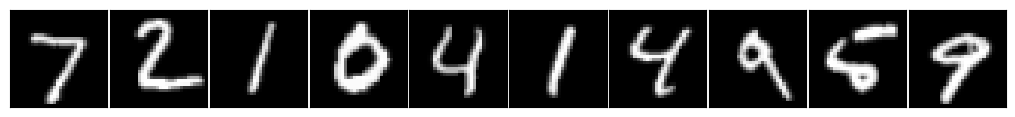

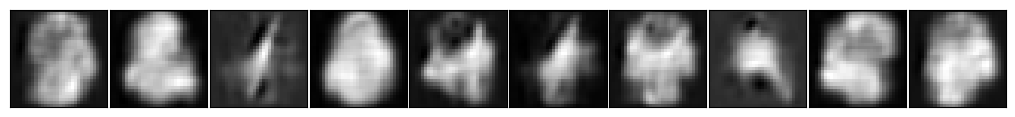

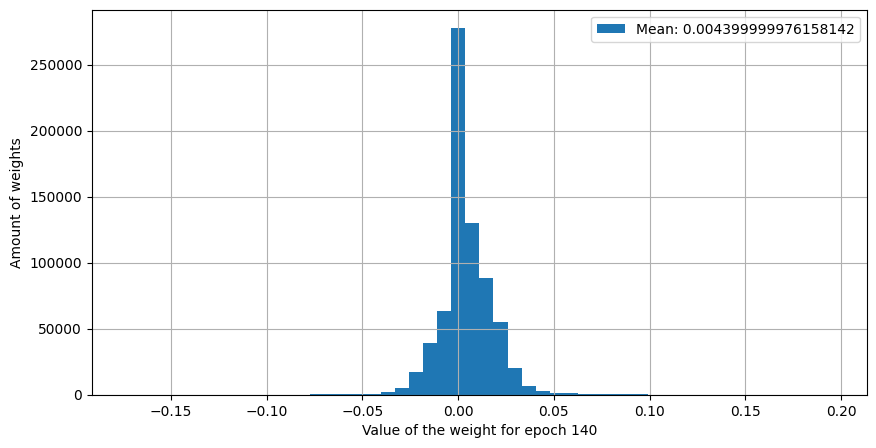

Interrupting by keyboard, returning trained model...


In [42]:
# treat the network as a discriminator that will check if two images are pairs or not.
import os
os.environ["WANDB_API_KEY"] = '449eb3fa3ebc473bba15c04ccfd03a676c074f00'
#os.environ["WANDB_MODE"] = "online"

cmap = 'gray'
EPOCHS = 3000

BATCH_SIZE_LOOP = 64  # Number of images per batch
PAIRS_TO_PICK = 128   # Total length of the dataset
EPOCH_REPORT = 10
N_TRAIN = PAIRS_TO_PICK  

config = {
  "dataset": "MNIST-FMNIST",
  "machine": "Colab",
  "model": model_name,
  "loss_function": loss_name,
  "image_size": IMG_SIZE,
  "learning_rate": LR,
  "batch_size_loop": BATCH_SIZE_LOOP,
  "batch_size_paired": PAIRS_TO_PICK,
  "epochs": EPOCHS
}

wandb.init(name=f'{loss_name}-{BATCH_SIZE_LOOP}/{PAIRS_TO_PICK}bs',project=f"FMNIST-{model_name}-{CONVEXIFY}-{loss_name}-t", entity="icnn-23", config=config)

X_paired = X[:].reshape(-1, CHANNELS, IMG_SIZE, IMG_SIZE)[:PAIRS_TO_PICK]
Y_paired = transp_Xt_emd[:].reshape(-1, CHANNELS, IMG_SIZE, IMG_SIZE)[:PAIRS_TO_PICK]

X_train = Variable(X_paired[:N_TRAIN], requires_grad=True)
Y_train = Variable(Y_paired[:N_TRAIN], requires_grad=True)

X_test = X_train[:10].to(DEVICE).requires_grad_(True)
Y_test = Y_train[:10].to(DEVICE).requires_grad_(True)

assert X_train.shape == (N_TRAIN, 3, IMG_SIZE, IMG_SIZE)

del X_paired, Y_paired

model_dict = {model_name:phi}

phi_trained = train_conv(model_dict, X_train, Y_train, X_test, Y_test, lamb=1e-5, EPOCHS=EPOCHS, BATCH_SIZE_LOOP=BATCH_SIZE_LOOP, EPOCH_REPORT=EPOCH_REPORT)


### Dense network training

In [8]:
def train_dense(model, X, Y, X_test, EPOCHS, BATCH_SIZE_LOOP, EPOCH_REPORT):
    
    phi = model

    try:
        for epoch in range(EPOCHS):

            permutation = torch.randperm(X.size()[0])

            for i in range(0, X.size()[0], BATCH_SIZE_LOOP):

                indices = permutation[i:i+BATCH_SIZE_LOOP]
                image_x, image_y = X[indices].to(DEVICE), Y[indices].to(DEVICE)
                
                out = phi(image_x).squeeze()

                out = torch.autograd.grad(out, image_x, create_graph=True, retain_graph=True, only_inputs=True, grad_outputs=torch.ones(image_x.size()[0]).cuda().float())[0]

                loss = criterion(out, image_y)
                
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                
                if CONVEXIFY:
                    phi.convexify()

            if epoch % EPOCH_REPORT == 0:

                clear_output(wait=True)
                print(f'Epoch: {epoch}/{EPOCHS}')
                wandb.log({"loss": loss.item()}, step=epoch)
                print('| Training loss: ', loss.item())

                out = phi(X_test).squeeze(1)
                out = torch.autograd.grad(out, X_test, create_graph=True, retain_graph=True, only_inputs=True, grad_outputs=torch.ones(X_test.size()[0]).cuda().float())[0]

                fig1 = plot_images(X_test.reshape(-1, CHANNELS, IMG_SIZE, IMG_SIZE).cpu().detach().numpy(), 10, cmap='gray')
                fig2 = plot_images(out.reshape(-1, CHANNELS, IMG_SIZE, IMG_SIZE).cpu().detach().numpy(), 10, cmap='gray')
                wandb.log({'Images' : [wandb.Image(fig2img(fig1)), wandb.Image(fig2img(fig2))]}, step=epoch) 

                plt.show()
                
    except KeyboardInterrupt:
        print('Interrupting by keyboard, returning trained model...')
        return phi

    return phi

In [9]:
model_name = 'dense_icnn'

phi = dense_icnn.DenseICNN(IMG_SIZE**2*CHANNELS)

CONVEXIFY = False
loss_name = 'l1_loss'

#losses = {'l1_loss':F.l1_loss, 'l2_loss':F.mse_loss, 'percep': VGGPerceptualLoss(DEVICE=DEVICE)}
losses = {'l1_loss':F.l1_loss, 'l2_loss':F.mse_loss}

phi.to(DEVICE)

criterion = losses[loss_name]

LR = 1e-3
optimizer = torch.optim.Adam(phi.parameters(), lr=LR, betas=(0.8, 0.99))

In [10]:
# treat the network as a discriminator that will check if two images are pairs or not.

os.environ["WANDB_API_KEY"] = '449eb3fa3ebc473bba15c04ccfd03a676c074f00'
#os.environ["WANDB_MODE"] = "online"

EPOCHS = 3000

BATCH_SIZE_LOOP = 64  # Number of images per batch
PAIRS_TO_PICK = 128   # Total length of the dataset
EPOCH_REPORT = 10
N_TRAIN = PAIRS_TO_PICK  

config = {
  "dataset": "MNIST-FMNIST",
  "machine": "Colab",
  "model": model_name,
  "loss_function": loss_name,
  "image_size": IMG_SIZE,
  "learning_rate": LR,
  "batch_size_loop": BATCH_SIZE_LOOP,
  "batch_size_paired": PAIRS_TO_PICK,
  "epochs": EPOCHS
}

wandb.init(name=f'{loss_name}-{BATCH_SIZE_LOOP}/{PAIRS_TO_PICK}bs',project=f"FMNIST-{model_name}-{CONVEXIFY}-{loss_name}-t", entity="icnn-23", config=config)

X_paired = X[:].reshape(-1, CHANNELS*IMG_SIZE*IMG_SIZE)[:PAIRS_TO_PICK]
Y_paired = transp_Xt_emd[:].reshape(-1, CHANNELS*IMG_SIZE*IMG_SIZE)[:PAIRS_TO_PICK]

X_train = Variable(X_paired[:N_TRAIN], requires_grad=True)
Y_train = Variable(Y_paired[:N_TRAIN], requires_grad=True)

X_test = X_train[:10].to(DEVICE).requires_grad_(True)
Y_test = Y_train[:10].to(DEVICE).requires_grad_(True)

print(X_train.shape)
assert X_train.shape == (N_TRAIN, CHANNELS * IMG_SIZE * IMG_SIZE)

del X_paired, Y_paired

phi_trained = train_dense(phi, X_train, Y_train, X_test, EPOCHS, BATCH_SIZE_LOOP, EPOCH_REPORT)

Epoch: 140/3000
| Training loss:  0.2927395701408386
Interrupting by keyboard, returning trained model...
